In [ ]:
# from __future__ import print_function, unicode_literals, absolute_import, division
# import sys
import numpy as np
# import matplotlib
# matplotlib.rcParams["image.interpolation"] = 'none'
# import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

In [ ]:
X = sorted(glob('/mnt/efs/aimbl_2025/student_data/S-LS/raw_bacteria/*.tif'))
Y = sorted(glob('/mnt/efs/aimbl_2025/student_data/S-LS/mask_bacteria/*.tif'))

In [ ]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

Normalize axis and fill small holes

In [ ]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 12/12 [00:03<00:00,  3.16it/s]


Split into train and validation dataset

In [ ]:
X_annotated=X[0:12]
rng = np.random.RandomState(42)
#ind = rng.permutation(len(X))
ind = rng.permutation(12)
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X_annotated[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X_annotated[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X_annotated))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  12
- training:        10
- validation:       2


In [6]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

importing model

In [7]:
from stardist.models import StarDist2D

ON_Stardist_model= StarDist2D(None, "Stardist_training_model", "/home/S-LS/AI-MBL-2025/masketeers/")

W0000 00:00:1756913344.291236  528870 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


Running model

In [8]:
Y_val_pred = [ON_Stardist_model.predict_instances(x, n_tiles=ON_Stardist_model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|██████████| 2/2 [01:09<00:00, 34.91s/it]


Plotting results

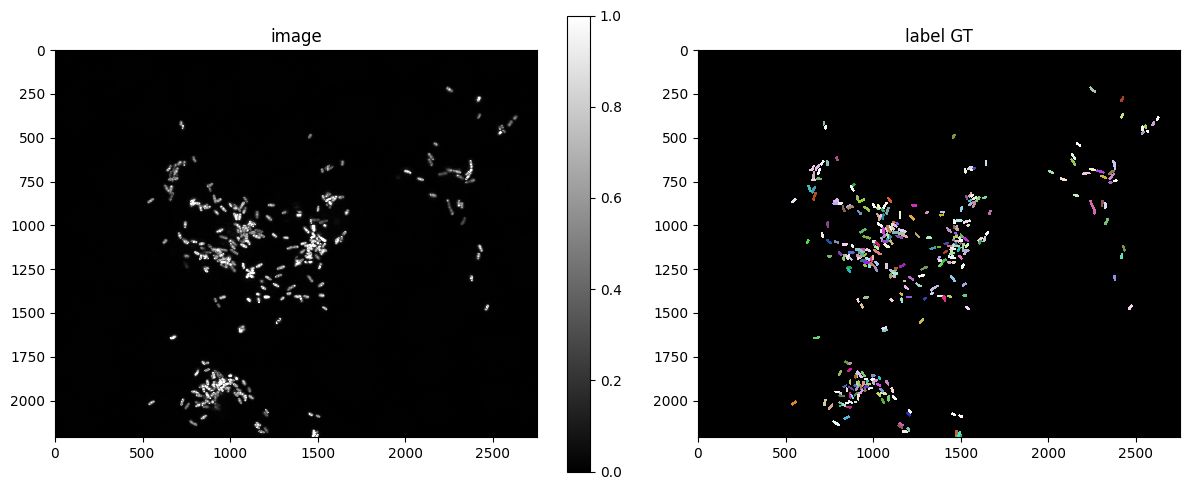

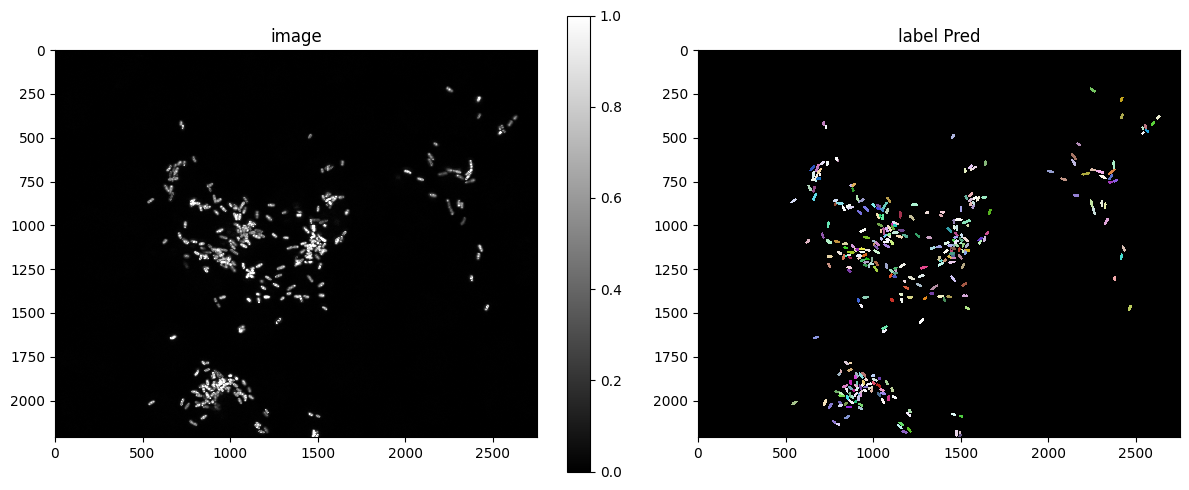

In [9]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")

initializing napari

In [1]:
import os
os.environ["DISPLAY"] = ':1001'

In [2]:
import napari
viewer=napari.Viewer()

In [12]:
print(X_val[0])

[[ 0.0003269   0.00457666  0.00490356 ...  0.00098071  0.00163452
   0.00196143]
 [ 0.00490356  0.00424975  0.00130762 ...  0.00130762  0.00359595
   0.00261523]
 [-0.0003269   0.00261523  0.00130762 ...  0.00163452  0.
   0.00098071]
 ...
 [ 0.00098071  0.00130762  0.00228833 ...  0.00130762  0.00130762
   0.00228833]
 [ 0.00261523  0.00294214  0.00261523 ...  0.00196143  0.00065381
   0.00196143]
 [ 0.00098071  0.00065381  0.00326904 ...  0.00359595  0.00163452
   0.00424975]]


In [3]:
import numpy as np
viewer.add_image(np.random.rand(128,128), name="raw_image")

<Image layer 'raw_image' at 0x7eddf070bf80>

In [ ]:
viewer.add_image(X_val[0], name="raw_image")
# viewer.add_labels(Y_val_pred[0], name='prediction')
#viewer.add_labels(Y_val[0],name='groundtruth')

: 